In [1]:
import pickle  # data loading
import gzip  # data loading
from scipy.stats.stats import pearsonr  # correlation

import numpy as np  # linear algebra
import matplotlib.pyplot as plt  # plotting

# output format
np.set_printoptions(precision=2)
np.seterr(all='raise') # elevate all warnings to errors

def load_mnist_data():
    """Loads the data, returns training_data, validation_data, test_data."""
    with gzip.open('mnist.pkl.gz', 'rb') as f:
        return pickle.load(f, encoding='latin1')
    
(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_mnist_data()

We have 50000 training images, 10000 validation images and 10000 test images, let's reshape them to 2-dimensional data:

In [2]:
x_train = x_train.reshape((50000, 28, 28))
x_val   = x_val.reshape((10000, 28, 28))
x_test  = x_test.reshape((10000, 28, 28))

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(50000, 28, 28)
(10000, 28, 28)
(10000, 28, 28)


The pixel values are between 0 and 1:

In [3]:
x_train.min(), x_train.max()

(0.0, 0.99609375)

## Random sampling of digits

The following function creates a set of random sample pixels

In [4]:
def create_sample(n):
     return np.random.randint(28, size=(n, 2))


The activation function sums over the sample pixels in an image

In [5]:
def activation(x, sample):
    return np.sum(x[sample[:,0],sample[:,1]])

Plotting some images and demonstrate activation function:

Activation on 5 is 6.5976562
Activation on 0 is 6.2070312
Activation on 4 is 5.5585938
Activation on 1 is 4.2382812
Activation on 9 is 5.2148438
Activation on 2 is 4.7539062
Activation on 1 is 5.0703125
Activation on 3 is 10.84375
Activation on 1 is 3.96875
Activation on 4 is 1.65625


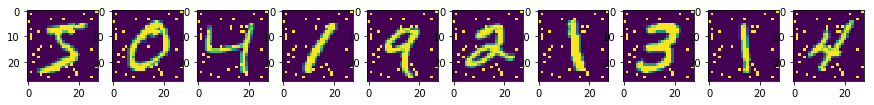

In [6]:
# some sampling points
sample = create_sample(40)

# plot first ten digits
plt.figure(figsize=(15,10))
for i in range(10):
    # highlight sample points in image
    digit = x_train[i]
    digit_with_highlight = digit.copy()
    digit_with_highlight[sample[:,0], sample[:,1]] = 1.0

    # plot digit
    plt.subplot(1,10,i+1)
    plt.imshow(digit_with_highlight)
    
    print("Activation on", str(y_train[i]), "is", activation(digit, sample))

We can see that if we look at the sum over sample pixels, they respond higher on some digits and lower on others. But how stable are these biases?

## Activation values per digit for one specific pixel sample set

To evaluate the different activation values of one specific pixel set, the activations for different digit classes were grouped together here.

In [7]:
activations_per_digit = [[], [], [], [], [], [], [], [], [], [],]
for i in range(x_train.shape[0]):
    activations_per_digit[y_train[i]].append(activation(x_train[i], sample))
    

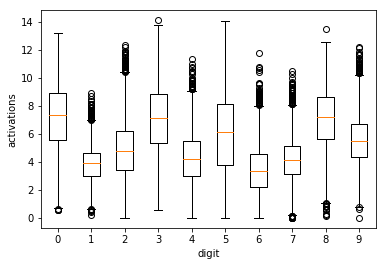

In [8]:
plt.boxplot(activations_per_digit, labels=list(range(10)))
plt.xlabel('digit')
plt.ylabel('activations')
None

## Correlations between activation vectors on 10 single digits



In [9]:
# manual implementation of pearsonr, just to be sure
def pcc(X, Y):
   
    X -= X.mean(0)
    Y -= Y.mean(0)
    
    # Standardise X and Y
    X /= X.std(0)
    Y /= Y.std(0)
 
    # Compute mean product
    return np.mean(X*Y)

v1 = np.random.normal(size=10)
v2 = np.random.normal(size=10)

# compare to reference implementation
print("comparing", v1, "\nand", v2)
print("scipy implementation", pearsonr(v1, v2)[0])
print("manual implementation", pcc(v1, v2))

comparing [ 0.05  0.45 -0.82  1.18  0.33  0.    0.32  0.08 -0.54 -0.2 ] 
and [ 0.45 -0.39 -0.38  0.36  1.49 -0.58 -1.16 -0.04  0.44  0.64]
scipy implementation 0.07048254439485485
manual implementation 0.0704825443948549


In [10]:
# prepare all the indicies for a specific digit class for lookup
indices_by_digit_class = []

for i in range(10):
    indices = np.argwhere(y_train == i)
    indices_by_digit_class.append(indices.reshape(-1))

In [11]:
def collect_correlations2(pixel_count, num_samples = 10000):
    correlations = []
    
    for i in range(num_samples):
        sample = create_sample(pixel_count)

        # create two random digit sets with digits 0, 1, 2, ..., 9
        activations1 = []
        activations2 = []

        for k in range(10):
            # find two random digits of class k
            index1 = np.random.choice(indices_by_digit_class[k])
            index2 = np.random.choice(indices_by_digit_class[k])

            #print(y_train[index1])
            #print(y_train[index2])

            # calculate the activation
            activations1.append(activation(x_train[index1], sample))
            activations2.append(activation(x_train[index2], sample))

        # calc pearson correlation
        try: 
            # c = pearsonr(activations1, activations2)[0]
            c = pcc(np.array(activations1), np.array(activations2))
            correlations.append(c)
        except:
            pass # skip values where one of the vectors is the zero vector
                        
            
    return correlations
        
pixel_counts = [10, 20, 40, 80]
correlations = list(map(collect_correlations2, pixel_counts))
    

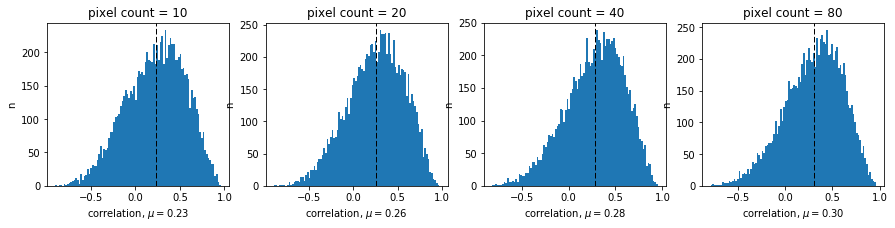

In [12]:
plt.figure(figsize=(15,3))

for i, pixel_count in enumerate(pixel_counts):
    ax = plt.subplot(1,4,i+1)
    ax.set_title("pixel count = "+str(pixel_count))
    ax.hist(correlations[i], bins=100)
    ax.set_xlabel('correlation, $\mu ='+'{:20,.2f}'.format(np.mean(correlations[i]))+'$')
    ax.set_ylabel('n')
    ax.axvline(np.mean(correlations[i]), color='k', linestyle='dashed', linewidth=1)